## Trello diagnostics

Get API key from database first

In [1]:
import pandas as pd
import requests
import json
import os
import datetime
import matplotlib.pyplot as plt
now = datetime.datetime.now().strftime("%Y%m%d")

# In keepass
tkey = '9c08153046fe279719eb6130c942b405'
ttok = 'b34ffebd32b0992fb98bd8c225d45ce691ee9c03af09d05ce0e9d2fd7fb5a1f7'

In [2]:
param = (
    ('key', tkey),
    ('token', ttok),
    ('fields','name,url'),
)

response = requests.get('https://api.trello.com/1/members/me/boards', params=param)
response

<Response [200]>

In [3]:
boardnames = ['Core_packages_to_EDI', 'NonCore_packages_to_EDI', 'New_packages_to_EDI']
boards = pd.DataFrame(json.loads(response.text))
boards = boards.loc[boards.name.isin(boardnames),:]
boards

,name,id,url
0,Core_packages_to_EDI,5cd3535c4761e02ef43daee6,https://trello.com/b/mCuKbYTO/corepackagestoedi
8,New_packages_to_EDI,5cdade8ab0b70061e661bd0f,https://trello.com/b/UOL3Tdhg/newpackagestoedi
9,NonCore_packages_to_EDI,5d1e619c05aa858fd1d68a64,https://trello.com/b/7oxEQcEY/noncorepackagest...


In [4]:
boards[boards.name=='NonCore_packages_to_EDI'].id.values[0]

'5d1e619c05aa858fd1d68a64'

In [5]:
def get_cards(boardname):
    boardid = boards[boards.name==boardname].id.values[0]
    param = (
        ('key', tkey),
        ('token', ttok),
        ('fields','idList,name,url'),
    )
    response = requests.get('https://api.trello.com/1/boards/'+str(boardid)+'/cards',
                            params=param)
    cards = pd.DataFrame(json.loads(response.text))
    cards = cards.rename(columns={'id':'idCards', 'name':'nameCards'})
    param = (
        ('key', tkey),
        ('token', ttok),
        ('fields','name,url'),
    )
    response = requests.get('https://api.trello.com/1/boards/'+str(boardid)+'/lists',
                            params=param)
    lists = pd.DataFrame(json.loads(response.text))
    lists = lists.rename(columns={'id':'idList','name':'nameList'})
    df = cards.merge(lists, how='left', left_on='idList', right_on='idList')
    df['Board'] = boardname.split('_')[0]
    return(df)


In [6]:
df_c = get_cards('Core_packages_to_EDI')
df_nc = get_cards('NonCore_packages_to_EDI')
df_n = get_cards('New_packages_to_EDI')

df = pd.concat([df_c, df_nc, df_n])

In [7]:
df_gby = df.groupby(['Board','nameList'])
pkgs = df_gby.count().reset_index()
pkgs

,Board,nameList,idCards,idList,nameCards,url
0,Core,Published to EDI,59,59,59,59
1,Core,To Do,3,3,3,3
2,New,In PI review,5,5,5,5
3,New,In Progress/Staged,5,5,5,5
4,New,Published to EDI,5,5,5,5
5,New,To Do,106,106,106,106
6,NonCore,In PI review,11,11,11,11
7,NonCore,In Progress/Staged,4,4,4,4
8,NonCore,Published to EDI,29,29,29,29
9,NonCore,To Do,15,15,15,15


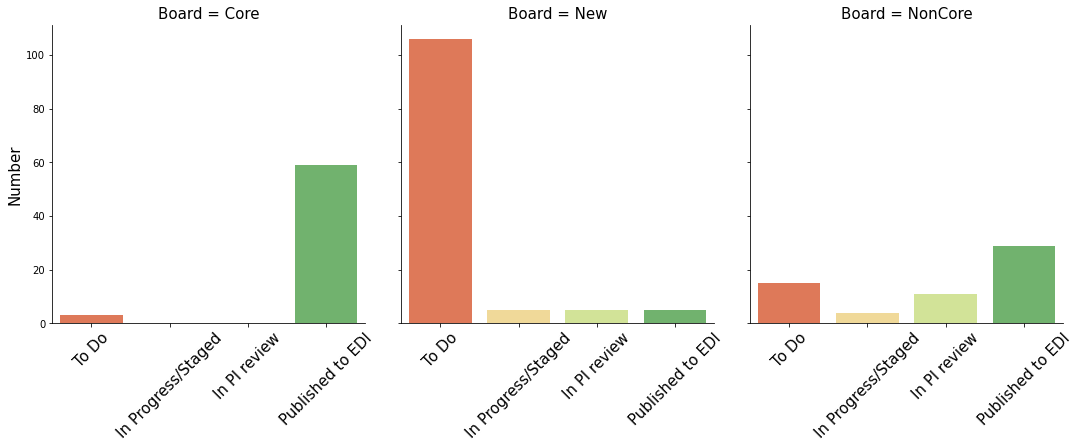

In [8]:
import seaborn as sns
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15


catorder = ['To Do','In Progress/Staged','In PI review','Published to EDI']
g = sns.catplot(x='nameList', y='idCards', col='Board', data=pkgs, kind='bar',
                order=catorder,palette='RdYlGn')
g.axes[0,0].set_ylabel('Number')
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[0,2].set_xlabel('')
g.set_xticklabels(rotation=45)

g.savefig(os.path.expanduser(
    "/Users/gmaurer/GD_gmaurer.jrn.lter/IM/figures/JRN_category_progress{0}.png".format(now)),
            dpi=150)

In [9]:
pkgs.pivot(index='nameList', columns='Board', values='idCards')

Board,Core,New,NonCore
nameList,,,
In PI review,NaN,5.0,11.0
In Progress/Staged,NaN,5.0,4.0
Published to EDI,59.0,5.0,29.0
To Do,3.0,106.0,15.0


## The old fashioned way.

In [26]:
pkgs = pd.DataFrame({'Core':{'On EDI':59, 'PI Review':0, 'In progress':0, 'To Do':2},
                    'Non_core':{'On EDI':22, 'PI Review':4, 'In progress':17, 'To Do':16}})#,
#                    'New':{'On EDI':3, 'PI Review':1, 'In progress/Staged':5, 'To Do':107}})
pkgs['loc'] = pkgs.index

In [27]:

pkgs_melt = pkgs.melt(id_vars=['loc'], value_vars=['Core','Non_core'])
pkgs_melt

,loc,variable,value
0,On EDI,Core,59
1,PI Review,Core,0
2,In progress,Core,0
3,To Do,Core,2
4,On EDI,Non_core,22
5,PI Review,Non_core,4
6,In progress,Non_core,17
7,To Do,Non_core,16


Text(0.5, 6.800000000000011, '')

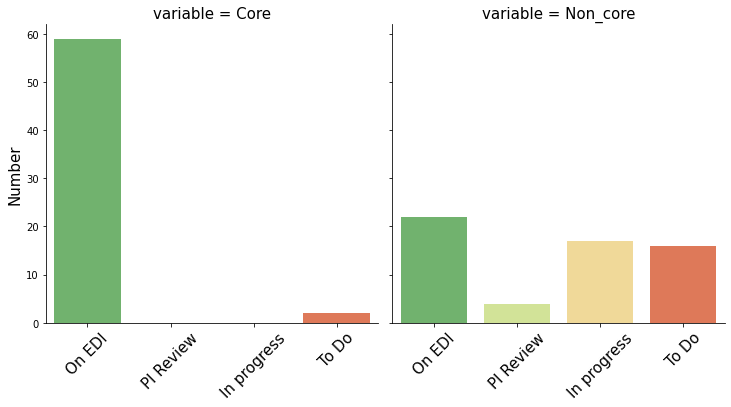

In [28]:
g = sns.catplot(x='loc', y='value', col='variable', data=pkgs_melt, kind='bar', palette='RdYlGn_r')
g.set_xticklabels(rotation=45)
#plt.ylabel('Number')
g.axes[0,0].set_ylabel('Number')
g.axes[0,1].set_xlabel('')
g.axes[0,0].set_xlabel('')

#g.savefig(os.path.expanduser(
#    "/Users/gmaurer/GD_gmaurer.jrn.lter/IM/figures/JRN_category_progress_manual.png"),
#            dpi=150)